In [1]:
#Training Code
# Importing Libraries

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint

# Importing Tabular Data (Metadata)

tabular_data = pd.read_csv('D:/Data/HAM10000_metadata.csv')

print(tabular_data.head())

# Importing Image Data with Pixel Values and Labels

data = pd.read_csv('D:/Data/hmnist_28_28_RGB.csv')

# Splitting data into features (x) and labels (y)

x = data.drop('label', axis=1)
y = data['label']

# Oversampling to Overcome Class Imbalance

oversample = RandomOverSampler(random_state=42)
x_resampled, y_resampled = oversample.fit_resample(x, y)

# Reshaping x to match image dimensions (28, 28, 3)

x_resampled = np.array(x_resampled).reshape(-1, 28, 28, 3)

print('Shape of x after oversampling and reshaping:', x_resampled.shape)

# Standardizing Data

mean = np.mean(x_resampled)
std = np.std(x_resampled)
x_resampled = (x_resampled - mean) / std
np.save('mean.npy', mean)
np.save('std.npy', std)

# Splitting Data into Training and Testing Sets

X_train, X_test, Y_train, Y_test = train_test_split(
    x_resampled, y_resampled, test_size=0.2, random_state=1
)

print(f'Training set size: {X_train.shape}, Testing set size: {X_test.shape}')

# Building the CNN Model

model = Sequential([
    Input(shape=(28, 28, 3)),  # Adjusted input shape to match data
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

model.summary()

# Callback to save the best model

callback = ModelCheckpoint(
    filepath='best_model.keras',  # Changed to .keras extension
    monitor='val_accuracy',       # Monitoring validation accuracy
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compiling the Model

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Training the Model

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=20,
    callbacks=[callback]
)

model.save('final_model.h5')
print("Saved 'final_model.h5'")


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


C:\Users\hp\.conda\envs\tf\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\hp\.conda\envs\tf\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Shape of x after oversampling and reshaping: (46935, 28, 28, 3)
Training set size: (37548, 28, 28, 3), Testing set size: (9387, 28, 28, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                 

In [2]:
#Testing Code
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the correct class labels mapping
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
# Alternatively, use a dictionary
labels_dict = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'nv',
    5: 'vasc',
    6: 'mel'
}

print("Class labels:", class_labels)

# Load the trained model (ensure you're using the correct model file)
model = tf.keras.models.load_model('final_model.h5')  # Use the correct model filename

# Load mean and std from training
mean = np.load('mean.npy')
std = np.load('std.npy')

# Define the image preprocessing function
def preprocess_image(image):
    image = image.resize((28, 28))  # PIL uses (width, height)
    image = np.asarray(image)
    print(f'Image shape after resizing: {image.shape}')  # Should output (28, 28, 3)
    image = (image - mean) / std  # Standardize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Path to the image you want to test
image_path = 'D:/Data/HAM10000_images_part_2/ISIC_0029486.jpg'

# Check if the image exists
if not os.path.isfile(image_path):
    raise FileNotFoundError(f"The image file '{image_path}' does not exist.")

# Open and preprocess the image
image = Image.open(image_path).convert('RGB')  # Ensure image has 3 channels
processed_image = preprocess_image(image)

# Make prediction
predictions = model.predict(processed_image)

# Get predicted class index and name
predicted_class_idx = np.argmax(predictions, axis=1)[0]

# Use the correct mapping to get the class name
predicted_class = class_labels[predicted_class_idx]
# Or if using labels_dict:
# predicted_class = labels_dict[predicted_class_idx]

confidence = predictions[0][predicted_class_idx]

# Print result
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence}")

Class labels: ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
Image shape after resizing: (28, 28, 3)
1/1 [==============================] - 0s 352ms/step
Predicted Class: vasc
Confidence: 0.9999996423721313


In [3]:
#Testing Code on all images
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm  # For progress bar

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the correct class labels mapping
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
label_to_index = {label: idx for idx, label in enumerate(class_labels)}
index_to_label = {idx: label for idx, label in enumerate(class_labels)}

print("Class labels:", class_labels)

# Load the trained model
model = tf.keras.models.load_model('final_model.h5')  # Ensure this filename matches your trained model

# Load mean and std from training
mean = np.load('mean.npy')
std = np.load('std.npy')

# Define the image preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure image has 3 channels
    image = image.resize((28, 28))  # PIL uses (width, height)
    image = np.asarray(image)
    image = (image - mean) / std  # Standardize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Paths to the image directories
image_dir_1 = 'D:/Data/HAM10000_images_part_1'
image_dir_2 = 'D:/Data/HAM10000_images_part_2'

# Load the metadata
metadata = pd.read_csv('D:/Data/HAM10000_metadata.csv')

# Mapping of image IDs to file paths
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in list(
    map(lambda x: os.path.join(image_dir_1, x), os.listdir(image_dir_1))
) + list(
    map(lambda x: os.path.join(image_dir_2, x), os.listdir(image_dir_2))
)}

# Add file paths to the DataFrame
metadata['image_path'] = metadata['image_id'].map(imageid_path_dict.get)

# Map diagnostic labels to numerical labels
metadata['true_label'] = metadata['dx'].map(label_to_index.get)

# Initialize counters
total_images = len(metadata)
correct_predictions = 0
incorrect_predictions = 0

# Initialize list to store prediction results
results = []

# Loop over each image in the metadata
for idx, row in tqdm(metadata.iterrows(), total=total_images, ncols=80, leave=True, position=0):
    image_path = row['image_path']
    true_label_idx = row['true_label']
    true_label_name = index_to_label[true_label_idx]

    # Preprocess image
    processed_image = preprocess_image(image_path)

    # Make prediction without printing any progress bar
    predictions = model.predict(processed_image, verbose=0)
    confidence = np.max(predictions)

    # Get predicted class index and name
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class_name = index_to_label[predicted_class_idx]

    # Compare prediction with true label
    if predicted_class_idx == true_label_idx:
        correct_predictions += 1
    else:
        incorrect_predictions += 1

    # Store the result
    results.append({
        'image_id': row['image_id'],
        'true_label': true_label_name,
        'predicted_label': predicted_class_name,
        'confidence': confidence
    })

# Report results
print(f"\nTotal Images: {total_images}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")
print(f"Accuracy: {correct_predictions / total_images * 100:.2f}%")

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Save results to CSV
results_df.to_csv('prediction_results.csv', index=False)
print("Saved prediction results to 'prediction_results.csv'")

Class labels: ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']


100%|█████████████████████████████████████| 10015/10015 [37:32<00:00,  4.45it/s]


Total Images: 10015
Correct Predictions: 9559
Incorrect Predictions: 456
Accuracy: 95.45%
Saved prediction results to 'prediction_results.csv'



📊 Classification Report:
              precision    recall  f1-score   support

       akiec       0.97      1.00      0.98       327
         bcc       0.92      1.00      0.96       514
         bkl       0.89      0.96      0.93      1099
          df       0.95      1.00      0.97       115
          nv       0.99      0.94      0.97      6705
        vasc       0.97      1.00      0.98       142
         mel       0.84      0.98      0.90      1113

    accuracy                           0.95     10015
   macro avg       0.93      0.98      0.96     10015
weighted avg       0.96      0.95      0.96     10015


🧩 Confusion Matrix:
[[ 327    0    0    0    0    0    0]
 [   0  513    0    0    1    0    0]
 [   0    3 1060    0   28    0    8]
 [   0    0    0  115    0    0    0]
 [  11   40  123    6 6316    5  204]
 [   0    0    0    0    0  142    0]
 [   0    0    7    0   20    0 1086]]


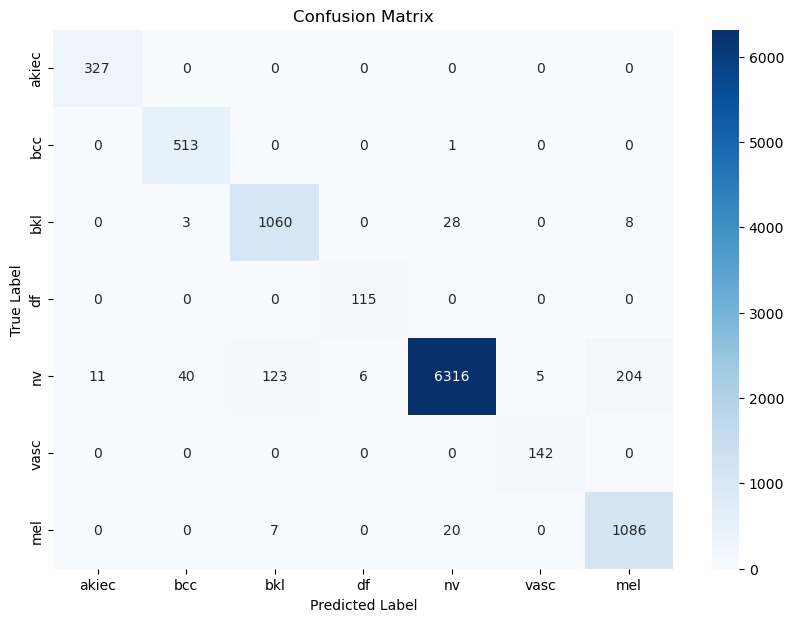

In [4]:
#الاضافة امتع مصفوفة التشتت وتقارير التصنيف والمقاييس اللي فيها
from sklearn.metrics import classification_report, confusion_matrix

# تحويل أسماء التصنيفات إلى أرقام باستخدام القاموس
y_true = results_df['true_label'].map(label_to_index)
y_pred = results_df['predicted_label'].map(label_to_index)

# طباعة تقرير التصنيف
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# طباعة مصفوفة الالتباس
print("\n🧩 Confusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

# ======= رسم مصفوفة الالتباس بشكل ملون =======

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()